In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import shap

# 데이터 로드
df = pd.read_csv('./encoded_data.csv')

# change_date 열을 제외한 나머지 열 선택
X = df.drop(columns=['change_date'])
y = df['change_date'].values  # 예측값

# 결측값 처리 (예: 평균값으로 대체)
X.replace('-', np.nan, inplace=True)
X = X.astype(np.float32)
X.fillna(X.mean(), inplace=True)

y = y.astype(np.float32)

# train/test 데이터셋 나누기 (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# train 데이터셋의 일부를 다시 train(sub)/val 데이터셋으로 나누기 (80% sub(train), 20% val)
X_sub, X_val, y_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_sub = scaler.transform(X_sub)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Sequential 모델 생성
# Dropout 추가 - 과적합 방지
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_dim=X.shape[1], activation='relu'),
    tf.keras.layers.Dropout(0.2),  # 20% 드롭아웃 추가
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # 20% 드롭아웃 추가
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# 회귀를 위한 손실 함수(mean squared error)와 메트릭스(mean absolute error) 사용하여 모델 컴파일
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), metrics=['mean_absolute_error'])

model.summary()

C:\Users\user\AppData\Local\Temp\ipykernel_14916\3090669732.py:11: DtypeWarning: Columns (4,5,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./encoded_data.csv')
D:\ANACONDA3_ENVS\DR\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 128)                 │          37,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,257 (188.50 KB)

 Trainable params: 48,257 (188.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000


C:\Users\user\AppData\Local\Temp\ipykernel_34516\2586548293.py:11: DtypeWarning: Columns (4,5,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./encoded_data.csv')
D:\ANACONDA3_ENVS\DR\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 40330.3555 - mean_absolute_error: 53.6512 - val_loss: 2223.7170 - val_mean_absolute_error: 46.9678
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2128.4268 - mean_absolute_error: 45.9241 - val_loss: 1821.7761 - val_mean_absolute_error: 42.4739
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1735.8674 - mean_absolute_error: 41.4366 - val_loss: 1492.3767 - val_mean_absolute_error: 38.4010
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1424.0597 - mean_absolute_error: 37.4873 - val_loss: 1223.7668 - val_mean_absolute_error: 34.7279
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1165.1245 - mean_absolute_error: 33.8605 - val_loss: 1003.7117 - val_mean_absolute_error: 31.4002
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 957.3060 - mean_absolute_error: 30.6367 - val_loss: 823.8922 - val_mean_absolute_error: 28.3928
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 783.6726 - mean_abs

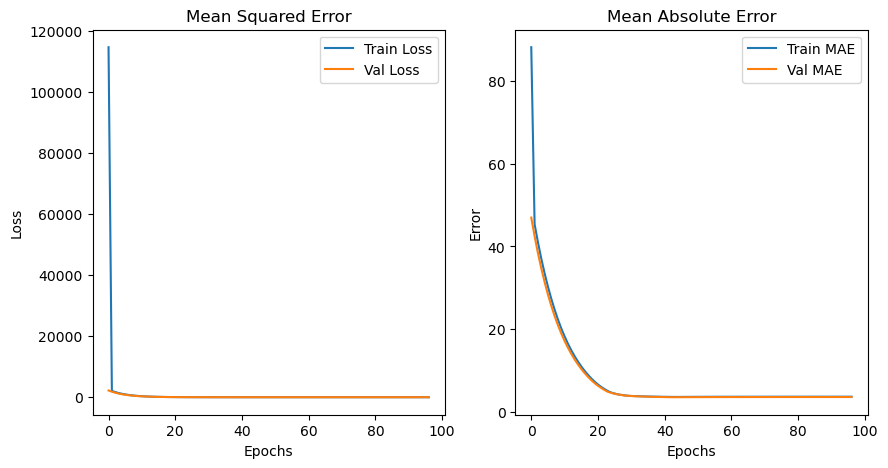

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 18.5225 - mean_absolute_error: 3.7437
Test Loss: 18.063013076782227
Test MAE: 3.704946279525757
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 17.5067 - mean_absolute_error: 3.6285
Validation Loss: 17.761199951171875
Validation MAE: 3.656024694442749
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
R2 Score: -0.0011636784613824336


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import shap

# 데이터 로드
df = pd.read_csv('./encoded_data.csv')

# change_date 열을 제외한 나머지 열 선택
X = df.drop(columns=['change_date'])
y = df['change_date'].values  # 예측값

# 결측값 처리 (예: 평균값으로 대체)
X.replace('-', np.nan, inplace=True)
X = X.astype(np.float32)
X.fillna(X.mean(), inplace=True)

y = y.astype(np.float32)

# train/test 데이터셋 나누기 (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# train 데이터셋의 일부를 다시 train(sub)/val 데이터셋으로 나누기 (80% sub(train), 20% val)
X_sub, X_val, y_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_sub = scaler.transform(X_sub)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Sequential 모델 생성
# Dropout 추가 - 과적합 방지
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_dim=X.shape[1], activation='relu'),
    tf.keras.layers.Dropout(0.2),  # 20% 드롭아웃 추가
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # 20% 드롭아웃 추가
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# 회귀를 위한 손실 함수(mean squared error)와 메트릭스(mean absolute error) 사용하여 모델 컴파일
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), metrics=['mean_absolute_error'])

# 조기 종료 콜백 추가 - 과적합 방지
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(X_sub, y_sub, validation_data=(X_val, y_val), epochs=1000, batch_size=1000, callbacks=[early_stopping])

# 학습 결과 시각화 (학습 곡선 시각화)
plt.figure(figsize=(10, 5))

# subplot 1: Mean Squared Error 손실 함수의 변화
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# subplot 2: Mean Absolute Error 매트릭스의 변화
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()

plt.show()

# 모델 평가 - 테스트 데이터셋 사용
loss_test, mae_test = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss_test}')
print(f'Test MAE: {mae_test}')

# 모델 평가 - 검증 데이터셋 사용
loss_val, mae_val = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss_val}')
print(f'Validation MAE: {mae_val}')

# 예측값 생성
predictions = model.predict(X_val)

# 결정계수 계산
r2 = r2_score(y_val, predictions)
print(f'R2 Score: {r2}')

# # 잔차 플롯 (Residual Plot)
# residuals = y_val - predictions
# plt.figure(figsize=(12, 5))
# plt.scatter(predictions, residuals, alpha=0.3)
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals')
# plt.title('Residuals vs Predicted Values')
# plt.hlines(0, min(predictions), max(predictions), colors='red')
# plt.show()

# SHAP 값 계산
# shap.initjs()

# explainer = shap.Explainer(model.predict, X_sub)
# shap_values = explainer(X_val)

# # SHAP 값 시각화
# shap.summary_plot(shap_values, X_val, feature_names=X.columns.tolist())


In [1]:
# R2 Score: -146590862153009.25 결정계수가 - 마이너스라서 모델 성능 의미가 없어 나머지 시각화 및 특성중요도 진행 안함

## 2. 얼리스타핑 쓰고 확인